In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas
import pickle

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr


In [2]:
def str2bool(string):
    return string.lower() in ("yes", "true", "t", "1")

point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")

In [3]:
data_dir = here("data")
directory = here("data", "random_features", "summary")
files = os.listdir(directory)
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
files = [f for f in files if not (bool(point_pattern.search(f)) & bool(wa_pattern.search(f)))]
len(files)

44

In [4]:
paramlist = list(itertools.product(files, [True, False]))
len(paramlist)

88

In [5]:
def model(params):
#########################################     SET PARAMS    #########################################
    file         = params[0]
    hot_encode   = params[1]
    f            = file.split(sep="_")
    satellite    = f[0]
    bands        = f[1].replace("bands-", "")
    country_code = f[2]
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "").split(sep="-")
    mns          = f[6].replace("mn-", "").split(sep="-")
    limit_months = str2bool(f[7].replace("lm-", ""))
    crop_mask    = str2bool(f[8].replace("cm-", ""))
    weighted_avg = str2bool(f[9].replace("wa-", ""))
    years        = range(int(yrs[0]), int(yrs[1])+1)
    month_range  = list(range(int(mns[0]), int(mns[1])+1))
    
#########################################     READ DATA    #########################################
    fn = f"{directory}/{file}"
    features = pd.read_feather(fn)
    features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

    climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))
    
    drop_cols = ['district', 'year', 'yield_mt']
    
#########################################    JOIN CLIMATE VARS    #########################################  
    ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
    keep_cols = [*ndvi_cols, *drop_cols]
    climate_df = climate_df.loc[:, keep_cols]
    
    features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
    features = features[features.year <= max(climate_df.year)]
    
    crop_yield = features.copy().loc[:, tuple(drop_cols)]
    crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)
    
#########################################     HOT ENCODE    ###########################################
    if hot_encode:
        drop_cols.remove("district")
        features = pd.get_dummies(features, columns=["district"], drop_first=False)
    else:
        pass

#########################################    STANDARDIZE FEATURES    #########################################    
    features = features.set_index(drop_cols) 
    features_scaled = StandardScaler().fit_transform(features.values)
    features = pd.DataFrame(features_scaled, index=features.index).reset_index()
    features.columns = features.columns.astype(str)          

#########################################     K-FOLD SPLIT    #########################################
    x_all = features.drop(drop_cols, axis = 1) 
    y_all = np.log10(features.yield_mt.to_numpy() + 1)
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################
    ### SETUP
    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold  = KFold()
    ridge  = Ridge()   
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    ridge_reg.fit(x_train, y_train)
    best_model = ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    val_predictions = cross_val_predict(best_model, X = x_train, y = y_train, cv = kfold)   
    train_predictions = best_model.predict(x_train)
    test_predictions  = best_model.predict(x_test)

#########################################     DE-MEAN R2    #########################################    
    crop_yield["prediction"] = np.maximum(best_model.predict(x_all), 0)

    train_split = pd.DataFrame(np.repeat('train', len(x_train)), columns = ['split'], index = x_train.index)
    train_split = train_split.join(crop_yield.copy()[crop_yield.index.isin(x_train.index)])
    train_split['cv_prediction'] = np.maximum(val_predictions, 0)
    train_split["demean_cv_yield"] = train_split["log_yield"]-train_split.groupby('district')['log_yield'].transform('mean')
    train_split["demean_cv_prediction"] = train_split["cv_prediction"]-train_split.groupby('district')['cv_prediction'].transform('mean')

    test_split = pd.DataFrame(np.repeat('test', len(x_test)), columns = ['split'], index = x_test.index)
    test_split = test_split.join(crop_yield.copy()[crop_yield.index.isin(x_test.index)])
    test_split['cv_prediction'] = np.repeat(np.nan, len(x_test))
    test_split["demean_cv_yield"] = np.repeat(np.nan, len(x_test))
    test_split["demean_cv_prediction"] = np.repeat(np.nan, len(x_test))

    predictions = pd.concat([train_split, test_split])

#########################################     SAVE MODELS   #########################################  
#     model_fn_suffix = file.replace('_summary.feather', '')
#     k_model_fn  = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

#     with open(here('models', k_model_fn),'wb') as f:
#         pickle.dump(best_model, f)

#########################################     SAVE RESULTS    #########################################
    d = {
        'country'     : country_code,
        'satellite'   : satellite,
        'bands'       : bands,
        'num_features': num_features,
        'points'      : points, 
        'month_range' : f'{min(month_range)}-{max(month_range)}',
        
        'limit_months': limit_months,
        'crop_mask'   : crop_mask,
        'weighted_avg': weighted_avg,
        'hot_encode': hot_encode,

        'total_n': len(x_all),
        'train_n': len(x_train),
        'test_n' : len(x_test),

        'best_reg_param': list(ridge_reg.best_params_.values())[0],
        'mean_of_val_R2': ridge_reg.best_score_,
        'val_R2': r2_score(y_train, val_predictions),
        'val_r' : pearsonr(val_predictions, y_train)[0],
        'val_r2': pearsonr(val_predictions, y_train)[0] ** 2,

        'train_R2': r2_score(y_train, train_predictions),
        'train_r' : pearsonr(train_predictions, y_train)[0],
        'train_r2': pearsonr(train_predictions, y_train)[0] ** 2,

        'test_R2': r2_score(y_test, test_predictions),
        'test_r' : pearsonr(test_predictions, y_test)[0],
        'test_r2': pearsonr(test_predictions, y_test)[0] ** 2,

        'demean_cv_R2': r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction),
        'demean_cv_r':  pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0],
        'demean_cv_r2': pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0] ** 2,
    }
    return pd.DataFrame(data=d, index=[0])

In [6]:
# %%time    
# ##### With progress bar
# workers = os.cpu_count()
# if __name__ == "__main__":
#     output = []
#     for result in p_tqdm.p_umap(model, paramlist, num_cpus=workers):
#         output.append(result)
#     results = pd.concat(output).reset_index(drop=True)
#     today = date.today().strftime("%Y-%m-%d")
#     file_name = f'results_{today}.csv'
#     print(f"Saving results as: {file_name}\n\n")           
#     results.to_csv(here("data","results", file_name), index=False)

In [7]:
# %%time    
# #### No progress bar
# multiprocessing.set_start_method('spawn')
# workers = os.cpu_count()
# if __name__ == "__main__":
#     with multiprocessing.Pool(processes=workers) as pool:
#         output = []
#         for result in pool.imap_unordered(model, paramlist, chunksize=2):
#             output.append(result)
#     results = pd.concat(output).reset_index(drop=True)
#     today = date.today().strftime("%Y-%m-%d")
#     file_name = f'results_{today}.csv'
#     print(f"Saving results as: {file_name}\n\n")           
#     results.to_csv(here("data","results", file_name))

In [8]:
### TESTING
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
hot_encode   = True

#########################################     SET PARAMS    #########################################
# file         = params[0]
# hot_encode   = params[1]
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

drop_cols = ['district', 'year', 'yield_mt']

#########################################    JOIN CLIMATE VARS    #########################################  
ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
keep_cols = [*ndvi_cols, *drop_cols]
climate_df = climate_df.loc[:, keep_cols]

features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)          

features.yield_mt = np.log10(features.yield_mt.to_numpy() + 1)

#########################################     HOT ENCODE    ###########################################
if hot_encode:
    # features['district'] = features.district.astype('category')
    drop_cols.remove("district")
    features = pd.get_dummies(features, columns=["district"], drop_first=False)
else:
    pass

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = features.yield_mt
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

In [9]:
from glum import GeneralizedLinearRegressorCV as glmCV
from glum import GeneralizedLinearRegressor as glm
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="glum")

In [18]:
%%time
params   = {'alpha': np.logspace(-7, 7, base = 10, num = 15)}
params_2 = {'alpha': [1]}
kfold    = KFold(n_splits=5)
penalty  = np.concatenate([np.ones(x_train.shape[1]-72), np.zeros(72)+1e-18])
ridge_1  = glm(family="normal", P2=penalty, l1_ratio=0, random_state=42)   
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
search_1 = GridSearchCV(ridge_1, params, scoring = 'r2', cv = kfold)
search_1.fit(x_train, y_train)
model_1  = search_1.best_estimator_

print(f'Lambda search 1 complete. Best lambda: {model_1.alpha}. Val R2: {search_1.best_score_:.04f}')

results = []
for pen in params.get('alpha'):
    print(pen, end=" ")
    penalties = np.concatenate([
        np.repeat(model_1.alpha, x_train.shape[1]-72),
        np.repeat(pen, 72), 
    ])
    ridge_2 = glm(family="normal", P2=penalties, l1_ratio=0, random_state=42)  
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    search_2 = GridSearchCV(ridge_2, params_2, scoring = 'r2', cv = kfold)
    search_2.fit(x_train, y_train)
    results.append(search_2.best_score_)
    
print(f"\nLambda search 2 complete. Best lambda: {list(params.get('alpha'))[np.argmax(results)]}. Val R2: {results[np.argmax(results)]:.04f}")

penalties_final = np.concatenate([
    np.repeat(model_1.alpha, x_train.shape[1]-72),
    np.repeat(list(params.get('alpha'))[np.argmax(results)], 72), 
])

ridge_3  = glm(family="normal", P2=penalties_final, l1_ratio=0, random_state=42)   
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
search_3 = GridSearchCV(ridge_3, params_2, scoring = 'r2', cv = kfold)
search_3.fit(x_train, y_train)
model_3  = search_3.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
val_predictions = cross_val_predict(model_3, X = x_train, y = y_train, cv = kfold)   
train_predictions = model_3.predict(x_train)
test_predictions  = model_3.predict(x_test) 
r2_score(y_true=y_train, y_pred=val_predictions)

0.8046550799702112

In [11]:
# from prediction_utils import *
from prediction_utils_1 import *

In [12]:
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": np.logspace(-7, 7, base = 10, num = 15), # [1e-3,1e-2, 1e-1, 1e0,1e1,1e2,1e3,1e4,1e5,1e6],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "return_model": False,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": True,
    
    "fit_model_after_tuning": False,
    'static_lam_val': 0+1e-18,
    'static_lam_idxs': list(range(x_train.shape[1]-72, x_train.shape[1])),
    # "static_lam_idxs": list(range(0,x_train.shape[1]-72)),
    "intercept": True
}

In [13]:
%%time
kfold_results = kfold_solve_custom_split_col(
    X=x_train,
    y=y_train,
    locations=x_train.index,
    split_col=x_train.reset_index().index,
    num_folds=5,
    random_state=1991,
    **solver_kwargs
)
best_alpha_1_idx = interpret_kfold_results(kfold_results, "r2_score")[0][0][0]
best_alpha_1 = list(solver_kwargs.get('lambdas'))[best_alpha_1_idx]
preds = np.maximum(get_pred_truth_locs(kfold_results)[0].flatten(), 0)
truth = get_pred_truth_locs(kfold_results)[1].flatten()
locations = get_pred_truth_locs(kfold_results)[2].flatten()
print(
f"""Best alpha: {best_alpha_1}
Val R2: {r2_score(truth, preds)}"""
)

on fold (of 5): 0 linalg warning on lambda=1e-07: 
we will allow this model upon model selection
linalg warning on lambda=1e-06: 
we will allow this model upon model selection
linalg warning on lambda=1e-05: 
we will allow this model upon model selection
linalg warning on lambda=0.0001: 
we will allow this model upon model selection
linalg warning on lambda=0.001: 
we will allow this model upon model selection
linalg warning on lambda=0.01: 
we will allow this model upon model selection
linalg warning on lambda=0.1: 
we will allow this model upon model selection
linalg warning on lambda=1.0: 
we will allow this model upon model selection
linalg warning on lambda=10.0: 
we will allow this model upon model selection
linalg warning on lambda=100.0: 
we will allow this model upon model selection
linalg warning on lambda=1000.0: 
we will allow this model upon model selection
linalg warning on lambda=10000.0: 
we will allow this model upon model selection
linalg warning on lambda=100000.0: 


C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [14]:
solver_kwargs = {
    # set of possible hyperparameters to search over in cross-validation
    "lambdas": np.logspace(-7, 7, base = 10, num = 15), # [1e-3,1e-2, 1e-1, 1e0,1e1,1e2,1e3,1e4,1e5,1e6],
    # do you want to return the predictions from the model?
    "return_preds": True,
    # input the bounds used to clip predictions
    "return_model": False,
    # do you want to use an SVD solve or standard linear regression? (NB: SVD is much slower)
    "svd_solve": False,
    # do you want to allow hyperparameters to be chosen even if they lead to warnings about matrix invertibility?
    "allow_linalg_warning_instances": True,
    "fit_model_after_tuning": False,
    "static_lam_val": best_alpha_1,
    # 'static_lam_idxs': list(range(x_train.shape[1]-72, x_train.shape[1])),
    "static_lam_idxs": list(range(0, x_train.shape[1]-72)),
    "intercept": True
}

In [15]:
%%time
kfold_results = kfold_solve_custom_split_col(
    X=x_train,
    y=y_train,
    locations=x_train.index,
    split_col=x_train.reset_index().index,
    num_folds=5,
    random_state=1991,
    **solver_kwargs
)
best_alpha_2_idx = interpret_kfold_results(kfold_results, "r2_score")[0][0][0]
best_alpha_2 = list(solver_kwargs.get('lambdas'))[best_alpha_2_idx]
preds = np.maximum(get_pred_truth_locs(kfold_results)[0].flatten(), 0)
truth = get_pred_truth_locs(kfold_results)[1].flatten()
locations = get_pred_truth_locs(kfold_results)[2].flatten()
print(
f"""Best alpha: {best_alpha_2}
Val R2: {r2_score(truth, preds)}"""
)

on fold (of 5): 0 1 2 3 4 

Best alpha: 0.1
Val R2: 0.7958363137054077
CPU times: total: 10min 22s
Wall time: 2min 14s


C:\Users\Cullen\anaconda3\envs\mosaiks-env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [16]:
model, intercept_term = custom_ridge(
    X=x_train,
    y=y_train,
    lam=best_alpha_1, 
    intercept=True,
    static_lam_val = best_alpha_2,
    static_lam_idxs =list(range(x_train.shape[1]-72, x_train.shape[1])))

pred_test = np.maximum(np.asarray(x_test).dot(model) + intercept_term, 0)
r2_score(y_test, pred_test)

0.7295321171259241

holdout r2: 0.796
holdout Pearson R: 0.892




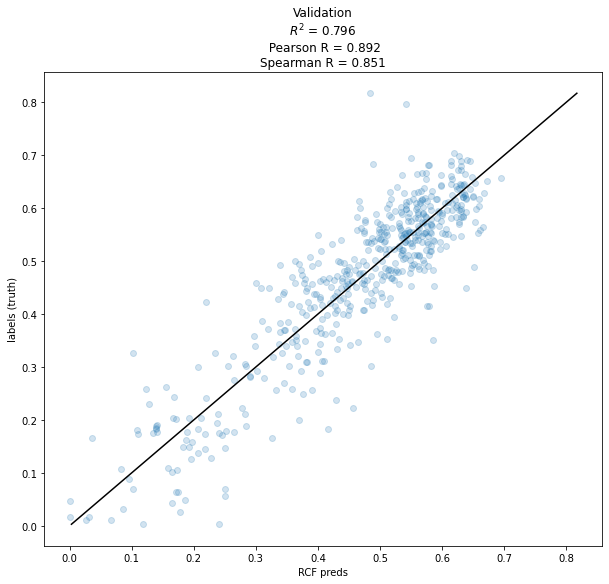

In [17]:
make_train_pred_scatterplot(task = "Validation", y_test = truth, preds_test = preds)

In [18]:
### TESTING
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
hot_encode   = True

#########################################     SET PARAMS    #########################################
# file         = params[0]
# hot_encode   = params[1]
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

drop_cols = ['district', 'year', 'yield_mt']

#########################################    JOIN CLIMATE VARS    #########################################  
ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
keep_cols = [*ndvi_cols, *drop_cols]
climate_df = climate_df.loc[:, keep_cols]

features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
features = features[features.year <= max(climate_df.year)]

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################     HOT ENCODE    ###########################################
if hot_encode:
    drop_cols.remove("district")
    features = pd.get_dummies(features, columns=["district"], drop_first=False)
else:
    pass

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()
features.columns = features.columns.astype(str)          

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = np.log10(features.yield_mt.to_numpy() + 1)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV    ###########################################
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
ridge  = Ridge()   
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
ridge_reg.fit(x_train, y_train)
best_model = ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
val_predictions = cross_val_predict(best_model, X = x_train, y = y_train, cv = kfold)   
train_predictions = best_model.predict(x_train)
test_predictions  = best_model.predict(x_test)

#########################################     DE-MEAN R2    #########################################    
crop_yield["prediction"] = np.maximum(best_model.predict(x_all), 0)

train_split = pd.DataFrame(np.repeat('train', len(x_train)), columns = ['split'], index = x_train.index)
train_split = train_split.join(crop_yield.copy()[crop_yield.index.isin(x_train.index)])
train_split['cv_prediction'] = np.maximum(val_predictions, 0)
train_split["demean_cv_yield"] = train_split["log_yield"]-train_split.groupby('district')['log_yield'].transform('mean')
train_split["demean_cv_prediction"] = train_split["cv_prediction"]-train_split.groupby('district')['cv_prediction'].transform('mean')

test_split = pd.DataFrame(np.repeat('test', len(x_test)), columns = ['split'], index = x_test.index)
test_split = test_split.join(crop_yield.copy()[crop_yield.index.isin(x_test.index)])
test_split['cv_prediction'] = np.repeat(np.nan, len(x_test))
test_split["demean_cv_yield"] = np.repeat(np.nan, len(x_test))
test_split["demean_cv_prediction"] = np.repeat(np.nan, len(x_test))

predictions = pd.concat([train_split, test_split])

#########################################     SAVE MODELS   #########################################  
#     model_fn_suffix = file.replace('_summary.feather', '')
#     k_model_fn  = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

#     with open(here('models', k_model_fn),'wb') as f:
#         pickle.dump(best_model, f)

#########################################     SAVE RESULTS    #########################################
d = {
    'country'     : country_code,
    'satellite'   : satellite,
    'bands'       : bands,
    'num_features': num_features,
    'points'      : points, 
    'month_range' : f'{min(month_range)}-{max(month_range)}',

    'limit_months': limit_months,
    'crop_mask'   : crop_mask,
    'weighted_avg': weighted_avg,
    'hot_encode': hot_encode,

    'total_n': len(x_all),
    'train_n': len(x_train),
    'test_n' : len(x_test),

    'best_reg_param': list(ridge_reg.best_params_.values())[0],
    'mean_of_val_R2': ridge_reg.best_score_,
    'val_R2': r2_score(y_train, val_predictions),
    'val_r' : pearsonr(val_predictions, y_train)[0],
    'val_r2': pearsonr(val_predictions, y_train)[0] ** 2,

    'train_R2': r2_score(y_train, train_predictions),
    'train_r' : pearsonr(train_predictions, y_train)[0],
    'train_r2': pearsonr(train_predictions, y_train)[0] ** 2,

    'test_R2': r2_score(y_test, test_predictions),
    'test_r' : pearsonr(test_predictions, y_test)[0],
    'test_r2': pearsonr(test_predictions, y_test)[0] ** 2,

    'demean_cv_R2': r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction),
    'demean_cv_r':  pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0],
    'demean_cv_r2': pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0] ** 2,
}

test_split["demean_test_yield"] = test_split["log_yield"]-test_split.groupby('district')['log_yield'].transform('mean')
test_split["demean_test_prediction"] = test_split["prediction"]-test_split.groupby('district')['prediction'].transform('mean')

print(f'Val  R2: {r2_score(y_train, val_predictions):0.2f}',
      f'\nTest R2: {r2_score(y_test, test_predictions):0.2f}',
     f'\n\nDemean Val  R2: {r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction):0.2f}',
     f'\nDemean Test R2: {r2_score(test_split.demean_test_yield, test_split.demean_test_prediction):0.2f}')

Val  R2: 0.72 
Test R2: 0.68 

Demean Val  R2: 0.14 
Demean Test R2: -0.08


In [28]:
# ### TESTING
# file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# hot_encode   = True

# #########################################     SET PARAMS    #########################################
# # file         = params[0]
# # hot_encode   = params[1]
# f            = file.split(sep="_")
# satellite    = f[0]
# bands        = f[1].replace("bands-", "")
# country_code = f[2]
# points       = f[3].replace("k-points", "")
# num_features = f[4].replace("-features", "")
# yrs          = f[5].replace("yr-", "").split(sep="-")
# mns          = f[6].replace("mn-", "").split(sep="-")
# limit_months = str2bool(f[7].replace("lm-", ""))
# crop_mask    = str2bool(f[8].replace("cm-", ""))
# weighted_avg = str2bool(f[9].replace("wa-", ""))
# years        = range(int(yrs[0]), int(yrs[1])+1)
# month_range  = list(range(int(mns[0]), int(mns[1])+1))

# #########################################     READ DATA    #########################################
# fn = f"{directory}/{file}"
# features = pd.read_feather(fn)
# features.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

# climate_df = pd.read_csv(here('data', 'climate', 'climate_summary.csv'))

# drop_cols = ['district', 'year', 'yield_mt']

# #########################################    JOIN CLIMATE VARS    #########################################  
# ndvi_cols = climate_df.columns[climate_df.columns.to_series().str.contains('ndvi')]
# keep_cols = [*ndvi_cols, *drop_cols]
# climate_df = climate_df.loc[:, keep_cols]

# features = features.set_index(drop_cols).join(climate_df.set_index(drop_cols)).reset_index()
# features = features[features.year <= max(climate_df.year)]

# crop_yield = features.copy().loc[:, tuple(drop_cols)]
# crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

# #########################################    STANDARDIZE FEATURES    #########################################    
# features = features.set_index(drop_cols) 
# features_scaled = StandardScaler().fit_transform(features.values)
# features = pd.DataFrame(features_scaled, index=features.index).reset_index()
# features.columns = features.columns.astype(str)          

# features.yield_mt = np.log10(features.yield_mt.to_numpy() + 1)

# #########################################     HOT ENCODE    ###########################################
# if hot_encode:
#     drop_cols.remove("district")
#     features = pd.get_dummies(features, columns=["district"], drop_first=False)
#     # features = mfe(
#     #     df = features,
#     #     var_cols=features.set_index(['district', 'year']).columns,
#     #     group_cols='district'
#     # )
# else:
#     pass

# #########################################     K-FOLD SPLIT    #########################################
# x_all = features.drop(drop_cols, axis = 1) 
# y_all = features.yield_mt
# x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)
# 
# #########################################     K-FOLD CV    ###########################################
# ### SETUP
# alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
# kfold  = KFold()
# ridge  = Ridge()   
# ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
# ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
# ridge_reg.fit(x_train, y_train)
# best_model = ridge_reg.best_estimator_
# ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
# val_predictions = cross_val_predict(best_model, X = x_train, y = y_train, cv = kfold)   
# train_predictions = best_model.predict(x_train)
# test_predictions  = best_model.predict(x_test)

# #########################################     DE-MEAN R2    #########################################    
# crop_yield["prediction"] = np.maximum(best_model.predict(x_all), 0)

# train_split = pd.DataFrame(np.repeat('train', len(x_train)), columns = ['split'], index = x_train.index)
# train_split = train_split.join(crop_yield.copy()[crop_yield.index.isin(x_train.index)])
# train_split['cv_prediction'] = np.maximum(val_predictions, 0)
# train_split["demean_cv_yield"] = train_split["log_yield"]-train_split.groupby('district')['log_yield'].transform('mean')
# train_split["demean_cv_prediction"] = train_split["cv_prediction"]-train_split.groupby('district')['cv_prediction'].transform('mean')

# test_split = pd.DataFrame(np.repeat('test', len(x_test)), columns = ['split'], index = x_test.index)
# test_split = test_split.join(crop_yield.copy()[crop_yield.index.isin(x_test.index)])
# test_split['cv_prediction'] = np.repeat(np.nan, len(x_test))
# test_split["demean_cv_yield"] = np.repeat(np.nan, len(x_test))
# test_split["demean_cv_prediction"] = np.repeat(np.nan, len(x_test))

# predictions = pd.concat([train_split, test_split])

# #########################################     SAVE MODELS   #########################################  
# #     model_fn_suffix = file.replace('_summary.feather', '')
# #     k_model_fn  = f'kfold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'

# #     with open(here('models', k_model_fn),'wb') as f:
# #         pickle.dump(best_model, f)

# #########################################     SAVE RESULTS    #########################################
# d = {
#     'country'     : country_code,
#     'satellite'   : satellite,
#     'bands'       : bands,
#     'num_features': num_features,
#     'points'      : points, 
#     'month_range' : f'{min(month_range)}-{max(month_range)}',

#     'limit_months': limit_months,
#     'crop_mask'   : crop_mask,
#     'weighted_avg': weighted_avg,
#     'hot_encode': hot_encode,

#     'total_n': len(x_all),
#     'train_n': len(x_train),
#     'test_n' : len(x_test),

#     'best_reg_param': list(ridge_reg.best_params_.values())[0],
#     'mean_of_val_R2': ridge_reg.best_score_,
#     'val_R2': r2_score(y_train, val_predictions),
#     'val_r' : pearsonr(val_predictions, y_train)[0],
#     'val_r2': pearsonr(val_predictions, y_train)[0] ** 2,

#     'train_R2': r2_score(y_train, train_predictions),
#     'train_r' : pearsonr(train_predictions, y_train)[0],
#     'train_r2': pearsonr(train_predictions, y_train)[0] ** 2,

#     'test_R2': r2_score(y_test, test_predictions),
#     'test_r' : pearsonr(test_predictions, y_test)[0],
#     'test_r2': pearsonr(test_predictions, y_test)[0] ** 2,

#     'demean_cv_R2': r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction),
#     'demean_cv_r':  pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0],
#     'demean_cv_r2': pearsonr(train_split.demean_cv_yield, train_split.demean_cv_prediction)[0] ** 2,
# }

# test_split["demean_test_yield"] = test_split["log_yield"]-test_split.groupby('district')['log_yield'].transform('mean')
# test_split["demean_test_prediction"] = test_split["prediction"]-test_split.groupby('district')['prediction'].transform('mean')

# print(f'Val  R2: {r2_score(y_train, val_predictions):0.2f}',
#       f'\nTest R2: {r2_score(y_test, test_predictions):0.2f}',
#      f'\n\nDemean Val  R2: {r2_score(train_split.demean_cv_yield, train_split.demean_cv_prediction):0.2f}',
#      f'\nDemean Test R2: {r2_score(test_split.demean_test_yield, test_split.demean_test_prediction):0.2f}')